In [ ]:
from google.colab import files
files.upload()

Saving test.xlsx to test.xlsx
Saving train.xlsx to train.xlsx


{'test.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\xa7\x0c\xebyh\x01\x00\x00\r\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder


#Train and Test data

In [ ]:
train = pd.read_excel('train.xlsx',parse_dates=[8])
test = pd.read_excel('test.xlsx',parse_dates=[8])

train.shape,test.shape

((9639, 12), (3135, 11))

In [ ]:
train.head()

,Application,Reviews,File_Size,Downloads,Category,Purchase_Price,Content Rating,Genres,Latest Updates,App_Version,Android_Supported,Overall_Rating
0,NaN,115.0,9318.4,10000,Free,0.0,Mature 17+,Comics,2018-07-13,5.0.12,5,1
1,365Scores - Live Scores,666521.0,25600.0,10000000,Free,0.0,Everyone,Sports,2018-07-29,5.5.9,4.1,1
2,4 in a row,47698.0,4198.4,5000000,Free,0.0,Everyone,Board,2016-04-12,1.0.21,1.5,1
3,8 Ball Pool,14201891.0,53248.0,100000000,Free,0.0,Everyone,Sports,2018-07-31,4.0.0,4.0.3,1
4,95Live -SG#1 Live Streaming App,4954.0,15360.0,1000000,Free,0.0,Teen,Dating,2018-08-01,8.7.2,4.2,1


In [ ]:
test.head(6)

,Application,Reviews,File_Size,Downloads,Category,Purchase_Price,Content Rating,Genres,Latest Updates,App_Version,Android_Supported
0,NaN,705.0,2048.0,100000.0,Free,0.0,Everyone,Productivity,2020-09-01,2.6.71,5.0 and up
1,Zorin Connect,412.0,4710.4,10000.0,Free,0.0,Everyone,Productivity,2020-09-01,1,4.0 and up
2,Zoomerang - Short Videos,153497.0,79872.0,10000000.0,Free,0.0,Everyone,Video Players & Editors,2020-11-27,18.7.1,5.0 and up
3,ZooCraft: Animal Family,416113.0,90112.0,10000000.0,Free,0.0,Everyone,Simulation,2020-11-26,3.9.5,4.4 and up
4,Zombie Defense 2: Offline TD Games,NaN,-1.0,10000.0,Free,0.0,Everyone 10+,Action,2020-10-06,6.29.37589,-1
5,ZOLEO,18.0,26624.0,5000.0,Free,0.0,Everyone,Social,2020-10-26,2.4,5.1 and up


In [ ]:
ID_COL, TARGET_COL = 'Application', 'Overall_Rating'

In [ ]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 9639 samples and 12 variables

Test contains 3135 samples and 11 variables

The dataset contains 10 features


#### 3. **Target Distribution**

In [ ]:
train[TARGET_COL].value_counts(normalize=True)

1    0.962859
0    0.037141
Name: Overall_Rating, dtype: float64

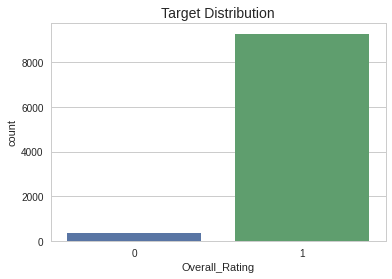

In [ ]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

**Severly Imbalanced**

# Data types

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Application        3134 non-null   object        
 1   Reviews            3111 non-null   float64       
 2   File_Size          3135 non-null   float64       
 3   Downloads          3132 non-null   float64       
 4   Category           3135 non-null   object        
 5   Purchase_Price     3135 non-null   float64       
 6   Content Rating     3132 non-null   object        
 7   Genres             3135 non-null   object        
 8   Latest Updates     3135 non-null   datetime64[ns]
 9   App_Version        3133 non-null   object        
 10  Android_Supported  3130 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 269.5+ KB


# Dropping unwanted features

In [ ]:
train = train.drop(['App_Version','Android_Supported'], axis = 1) 
test = test.drop(['App_Version','Android_Supported'], axis = 1) 

# **Null Value**

In [ ]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Overall_Rating    0.0
Latest Updates    0.0
Genres            0.0
Content Rating    0.0
Purchase_Price    0.0
Category          0.0
Downloads         0.0
File_Size         0.0
Reviews           0.0
Application       0.0
dtype: float64

In [ ]:
null_values_per_variable = 100 * (test.isnull().sum()/test.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Reviews           0.8
Content Rating    0.1
Downloads         0.1
Latest Updates    0.0
Genres            0.0
Purchase_Price    0.0
Category          0.0
File_Size         0.0
Application       0.0
dtype: float64

# **Models Analysis** 

**Since less than 1% of data of few features is missing, thus we may delete the null values**

In [ ]:

test =test.dropna()
train=train.dropna()


In [ ]:
#test.isnull().sum()

In [ ]:
y=train['Overall_Rating']
train = train.drop('Overall_Rating',axis=1)

In [ ]:
for attr in ['year', 'month', 'day', 'week', 'dayofweek']:                                                                     # running loop for extracting new features from date
  train[attr] = getattr(train['Latest Updates'].dt, attr)

for attr in ['year', 'month', 'day', 'week', 'dayofweek']:                                                                     # running loop for extracting new features from date
  test[attr] = getattr(test['Latest Updates'].dt, attr)

In [ ]:
train = train.drop(['Latest Updates'], axis = 1) 
test = test.drop(['Latest Updates'], axis = 1) 

In [ ]:
train=pd.concat([train, y],axis=1)

In [ ]:
train.head()

,Application,Reviews,File_Size,Downloads,Category,Purchase_Price,Content Rating,Genres,year,month,day,week,dayofweek,Overall_Rating
1,365Scores - Live Scores,666521.0,25600.0,10000000,0,0.0,1,40,2018,7,29,30,6,1
2,4 in a row,47698.0,4198.4,5000000,0,0.0,1,6,2016,4,12,15,1,1
3,8 Ball Pool,14201891.0,53248.0,100000000,0,0.0,1,40,2018,7,31,31,1,1
4,95Live -SG#1 Live Streaming App,4954.0,15360.0,1000000,0,0.0,4,14,2018,8,1,31,2,1
5,A&E - Watch Full Episodes of TV Shows,29708.0,19456.0,1000000,0,0.0,4,17,2018,7,16,29,0,1


In [ ]:
test.head()

,Application,Reviews,File_Size,Downloads,Category,Purchase_Price,Content Rating,Genres,year,month,day,week,dayofweek
1,Zorin Connect,412.0,4710.4,10000.0,0,0.0,0,33,2020,9,1,36,1
2,Zoomerang - Short Videos,153497.0,79872.0,10000000.0,0,0.0,0,45,2020,11,27,48,4
3,ZooCraft: Animal Family,416113.0,90112.0,10000000.0,0,0.0,0,38,2020,11,26,48,3
5,ZOLEO,18.0,26624.0,5000.0,0,0.0,0,39,2020,10,26,44,0
6,Zola,2409.0,81920.0,100000.0,0,0.0,0,24,2020,11,7,45,5


# Label Encoding

In [ ]:
le=LabelEncoder()
#train
train['Category']=le.fit_transform(train['Category'])
train['Content Rating']=le.fit_transform(train['Content Rating'])
train['Genres']=le.fit_transform(train['Genres'])

#test
test['Category']=le.fit_transform(test['Category'])
test['Content Rating']=le.fit_transform(test['Content Rating'])
test['Genres']=le.fit_transform(test['Genres'])

# Helper function to download prediction

In [ ]:
def download_preds(preds_test,preds_test_proba, file_name = 'IMT_Hyd_preds.csv'):

  ## 1. Setting the target column with our obtained predictions
  test[TARGET_COL] = preds_test
  test['prob']=preds_test_proba

  ## 2. Saving our predictions to a csv file

  test.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

# Train = Trn + Val----train-test-split

In [ ]:
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
trn, val = train_test_split(train, test_size=0.2, random_state = 1, stratify = train[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test[features]


In [ ]:
train.shape,test.shape

((9637, 14), (3104, 13))

In [ ]:
trn.shape, val.shape

((7709, 14), (1928, 14))

In [ ]:
X_trn.shape, y_trn.shape

((7709, 12), (7709,))

# SMOTE Over Sampling

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()

In [ ]:
#trn
X_trn_smote, y_trn_smote= smote.fit_sample(X_trn,y_trn)
#val
X_val_smote, y_val_smote= smote.fit_sample(X_val,y_val)

In [ ]:
from collections import Counter
print('#trn\nBefore SMOTE:' , Counter(y_trn))
print('After SMOTE:' , Counter(y_trn_smote))

print('\n#val\nBefore SMOTE:' , Counter(y_val))
print('After SMOTE:' , Counter(y_val_smote))

#trn
Before SMOTE: Counter({1: 7423, 0: 286})
After SMOTE: Counter({1: 7423, 0: 7423})

#val
Before SMOTE: Counter({1: 1856, 0: 72})
After SMOTE: Counter({1: 1856, 0: 1856})


# Decision Tree
Baseline Model

In [ ]:
clf1 = DecisionTreeClassifier(random_state = 1)
_ = clf1.fit(X_trn_smote, y_trn_smote)

#prediction
preds_val = clf1.predict(X_val_smote)
preds_val_proba = clf1.predict_proba(X_val_smote)


In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_val_smote, preds_val_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val_smote))]
p_fpr, p_tpr, _ = roc_curve(y_val_smote, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_val_smote, preds_val_proba[:,1])

print(auc_score1)

0.8987068965517242


**Plot and Results**

F1 Score
 0.9039836567926455
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1856
           1       0.86      0.95      0.90      1856

    accuracy                           0.90      3712
   macro avg       0.90      0.90      0.90      3712
weighted avg       0.90      0.90      0.90      3712



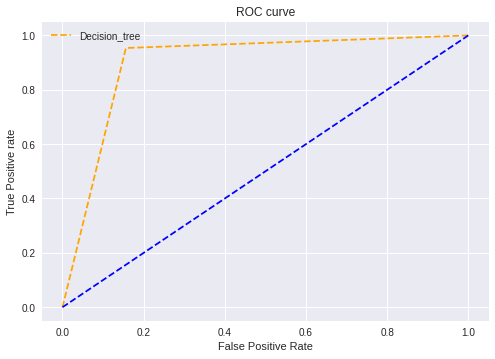

In [ ]:
print('F1 Score\n',f1_score(y_val_smote, preds_val))

print(metrics.classification_report(y_val_smote, preds_val))

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision_tree')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**Prediction**

In [ ]:
test['prob']=np.zeros((len(test)))

#prediction
preds_test=clf1.predict(X_test)

#probability
preds_test_proba=clf1.predict_proba(X_test)
download_preds(preds_test,preds_test_proba,file_name='dt_preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Decision Tree (Hyperparameter Tuned)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Params to tune
param={
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

In [ ]:
#tuning
clf2 = RandomizedSearchCV(DecisionTreeClassifier(),
                        param,
                        n_iter=20,
                        scoring='f1',
                        random_state=1)

In [ ]:
#Param results
search=clf2.fit(train[features],train[TARGET_COL ])
search.best_params_


{'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 0.6,
 'max_leaf_nodes': 16,
 'min_samples_split': 10}

In [ ]:
#Saving result
optimal_params={'class_weight': {0: 1, 1: 4},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 1,
 'max_leaf_nodes': 16,
 'min_samples_split': 2}

In [ ]:
#Validation Score
clf2=DecisionTreeClassifier(random_state=1, **optimal_params)
_=clf2.fit(X_trn_smote,y_trn_smote)

In [ ]:
#prediction
preds_val = clf2.predict(X_val_smote)
preds_val_proba = clf2.predict_proba(X_val_smote)

In [ ]:
# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_val_smote, preds_val_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val_smote))]
#p_fpr, p_tpr, _ = roc_curve(y_val_smote, random_probs, pos_label=1)

# auc scores
auc_score2 = roc_auc_score(y_val_smote, preds_val_proba[:,1])

print(auc_score2)

0.8118539417824763


**Plot and Results**

F1 Score
 0.7105666156202143
              precision    recall  f1-score   support

           0       1.00      0.19      0.31      1856
           1       0.55      1.00      0.71      1856

    accuracy                           0.59      3712
   macro avg       0.78      0.59      0.51      3712
weighted avg       0.78      0.59      0.51      3712



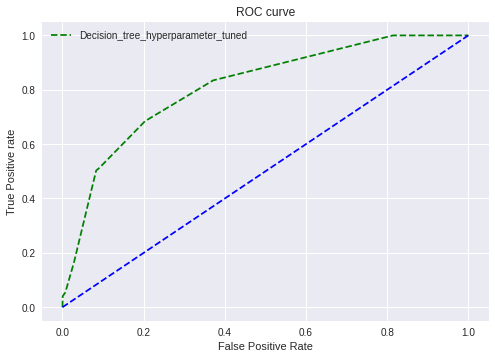

In [ ]:
print('F1 Score\n',f1_score(y_val_smote, preds_val))

print(metrics.classification_report(y_val_smote, preds_val))

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision_tree_hyperparameter_tuned')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**Prediction**

In [ ]:
test['prob']=np.zeros((len(test)))

#prediction
preds_test=clf2.predict(X_test)

#probability
preds_test_proba=clf2.predict_proba(X_test)
download_preds(preds_test,preds_test_proba,file_name='dt_preds_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(criterion = 'entropy', random_state = 42)
clf3.fit(X_trn_smote,y_trn_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#prediction
preds_val = clf3.predict(X_val_smote)
preds_val_proba = clf3.predict_proba(X_val_smote)

In [ ]:
# roc curve for models
fpr3, tpr3, thresh3 = roc_curve(y_val_smote, preds_val_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val_smote))]
p_fpr, p_tpr, _ = roc_curve(y_val_smote, random_probs, pos_label=1)

# auc scores
auc_score3 = roc_auc_score(y_val_smote, preds_val_proba[:,1])

print(auc_score3)

0.9654318937648633


**PLot and Results**

F1 Score
 0.9119683481701285
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1856
           1       0.84      0.99      0.91      1856

    accuracy                           0.90      3712
   macro avg       0.92      0.90      0.90      3712
weighted avg       0.92      0.90      0.90      3712



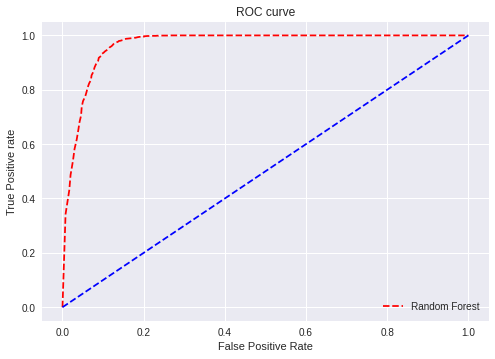

In [ ]:
print('F1 Score\n',f1_score(y_val_smote, preds_val))

print(metrics.classification_report(y_val_smote, preds_val))

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**Prediction**

In [ ]:
test['prob']=np.zeros((len(test)))
#prediction
preds_test=clf3.predict(X_test)
#probability
preds_test_proba=clf3.predict_proba(X_test)
download_preds(preds_test,preds_test_proba,file_name='rmf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Baseline Summary**

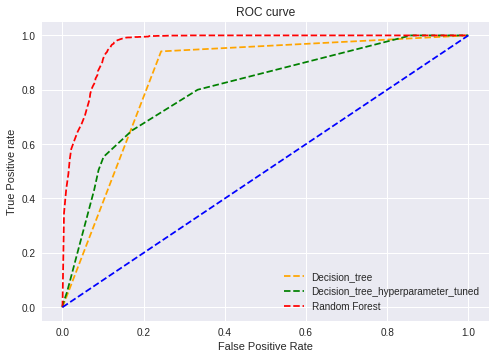

In [ ]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision_tree')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision_tree_hyperparameter_tuned')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# Validation Strategy
Startified KFold: Imbalanced Target Distrbution

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
target=train[TARGET_COL]

In [ ]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 9
  

  oofs = np.zeros(len(train))        #train prediction
  preds = np.zeros((len(test)))      #test prediction

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
    
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# SMOTE ##################################
    smote=SMOTE()

    #trn
    X_trn_smote, y_trn_smote= smote.fit_sample(X_trn,y_trn)
    #val
    X_val_smote, y_val_smote= smote.fit_sample(X_val,y_val)
    ####################################################



    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn_smote, y_trn_smote)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val_smote)[:, 1]    #oofs prediction
    preds_test = clf.predict_proba(X_test)[:, 1]        #test prediction

    fold_score = f1_score(y_val_smote, preds_val.round())   #fold score
    print(f'\nF1 score for validation set is {fold_score}')


    
    oofs = preds_val
    #print(X_val_smote.shape)
    print(oofs.shape)
    #print(preds.shape)
    
    preds += preds_test / N_SPLITS                    #mean test prediction

  oofs_score = f1_score(y_val_smote, oofs.round())    #combined OOFS score
  rocauc_score= roc_auc_score(y_val_smote, oofs.round())
  
  print(f'\n\nF1 score for oofs is {oofs_score}')
  
  print(metrics.classification_report(y_val_smote, oofs.round()))
  
  # roc curve for model
  fpr, tpr, thresh = roc_curve(y_val_smote, oofs, pos_label=1)
  
  # roc curve for tpr = fpr 
  random_probs = [0 for i in range(len(y_val_smote))]
  p_fpr, p_tpr, _ = roc_curve(y_val_smote, random_probs, pos_label=1)

  # auc scores
  auc_score = roc_auc_score(y_val_smote, oofs.round())
  print(f'\nRoc_auc score for oofs is {auc_score}\n')

  plt.style.use('seaborn')

  # plot roc curves
  plt.plot(fpr, tpr, linestyle='--',color='black', label='Random Forest Validation with Validation')
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

  # title
  plt.title('ROC curve')
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')

  plt.legend(loc='best')
  plt.savefig('ROC',dpi=300)
  plt.show();
  
  return oofs, preds
  

In [ ]:
dt_params={'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 0.2,
 'max_leaf_nodes': 64,
 'min_samples_split': 40}


# Decision Tree Validation


------------- Fold 1 -------------

F1 score for validation set is 0.7943713118474807
(2062,)

------------- Fold 2 -------------

F1 score for validation set is 0.741918932786044
(2062,)

------------- Fold 3 -------------

F1 score for validation set is 0.7366120218579236
(2062,)

------------- Fold 4 -------------

F1 score for validation set is 0.7429829389102918
(2062,)

------------- Fold 5 -------------

F1 score for validation set is 0.7712082262210797
(2062,)

------------- Fold 6 -------------

F1 score for validation set is 0.752513164193394
(2062,)

------------- Fold 7 -------------

F1 score for validation set is 0.768976897689769
(2062,)

------------- Fold 8 -------------

F1 score for validation set is 0.7765607886089815
(2062,)

------------- Fold 9 -------------

F1 score for validation set is 0.764519535374868
(2062,)


F1 score for oofs is 0.764519535374868
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1031

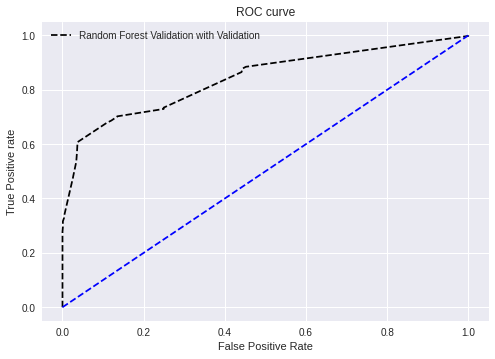

In [ ]:
#DT_Validation score With tuning
clf = DecisionTreeClassifier(**dt_params)
dt_oofs, dt_preds = run_clf_kfold(clf, train, test, features)

**Prediction**

In [ ]:
test['prob']=np.zeros((len(test)))
#prediction
preds_test=clf.predict(X_test)
#probability
preds_test_proba=clf.predict_proba(X_test)
download_preds(preds_test,preds_test_proba,file_name='DT_preds_val.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest Validation 


------------- Fold 1 -------------

F1 score for validation set is 0.8654404646660213
(2062,)

------------- Fold 2 -------------

F1 score for validation set is 0.8090507726269315
(2062,)

------------- Fold 3 -------------

F1 score for validation set is 0.7914847161572052
(2062,)

------------- Fold 4 -------------

F1 score for validation set is 0.8089136490250696
(2062,)

------------- Fold 5 -------------

F1 score for validation set is 0.8161530286928799
(2062,)

------------- Fold 6 -------------

F1 score for validation set is 0.7990074441687344
(2062,)

------------- Fold 7 -------------

F1 score for validation set is 0.8593913955928648
(2062,)

------------- Fold 8 -------------

F1 score for validation set is 0.86768581971534
(2062,)

------------- Fold 9 -------------

F1 score for validation set is 0.8476755687438179
(2062,)


F1 score for oofs is 0.8476755687438179
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1

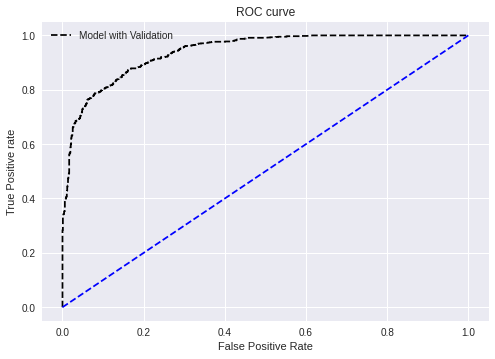

In [ ]:
#RMF_Validation score With tuning
clf = RandomForestClassifier(**dt_params)
rmf_oofs, rmf_preds = run_clf_kfold(clf, train, test, features)

# Gradient Boosting

# Light GBM

In [ ]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 9
  

  oofs = np.zeros(len(train))        #train prediction
  preds = np.zeros((len(test)))      #test prediction

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
    
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# SMOTE ##################################
    smote=SMOTE()

    #trn
    X_trn_smote, y_trn_smote= smote.fit_sample(X_trn,y_trn)
    #val
    X_val_smote, y_val_smote= smote.fit_sample(X_val,y_val)
    ####################################################



    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn_smote, y_trn_smote)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val_smote)[:, 1]    #oofs prediction
    preds_test = clf.predict_proba(X_test)[:, 1]        #test prediction

    fold_score = f1_score(y_val_smote, preds_val.round())   #fold score
    print(f'\nF1 score for validation set is {fold_score}')


    
    oofs = preds_val
    #print(X_val_smote.shape)
    print(oofs.shape)
    #print(preds.shape)
    
    preds += preds_test / N_SPLITS                    #mean test prediction

  oofs_score = f1_score(y_val_smote, oofs.round())    #combined OOFS score
  rocauc_score= roc_auc_score(y_val_smote, oofs.round())
  
  print(f'\n\nF1 score for oofs is {oofs_score}')
  
  print(metrics.classification_report(y_val_smote, oofs.round()))
  
  # roc curve for model
  fpr, tpr, thresh = roc_curve(y_val_smote, oofs, pos_label=1)
  
  # roc curve for tpr = fpr 
  random_probs = [0 for i in range(len(y_val_smote))]
  p_fpr, p_tpr, _ = roc_curve(y_val_smote, random_probs, pos_label=1)

  # auc scores
  auc_score = roc_auc_score(y_val_smote, oofs.round())
  print(f'\nRoc_auc score for oofs is {auc_score}\n')

  plt.style.use('seaborn')

  # plot roc curves
  plt.plot(fpr, tpr, linestyle='--',color='black', label='LGBM__Validation')
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

  # title
  plt.title('ROC curve')
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')

  plt.legend(loc='best')
  plt.savefig('ROC',dpi=300)
  plt.show();
  
  return oofs, preds
  

In [ ]:
from lightgbm import LGBMClassifier


------------- Fold 1 -------------

F1 score for validation set is 0.9510618651892889
(2062,)

------------- Fold 2 -------------

F1 score for validation set is 0.9680150517403576
(2062,)

------------- Fold 3 -------------

F1 score for validation set is 0.9598880597014926
(2062,)

------------- Fold 4 -------------

F1 score for validation set is 0.9739706578324657
(2062,)

------------- Fold 5 -------------

F1 score for validation set is 0.9790874524714828
(2062,)

------------- Fold 6 -------------

F1 score for validation set is 0.9531757070004635
(2062,)

------------- Fold 7 -------------

F1 score for validation set is 0.9694405265632347
(2062,)

------------- Fold 8 -------------

F1 score for validation set is 0.9644194756554307
(2062,)

------------- Fold 9 -------------

F1 score for validation set is 0.9648382559774965
(2062,)


F1 score for oofs is 0.9648382559774965
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     

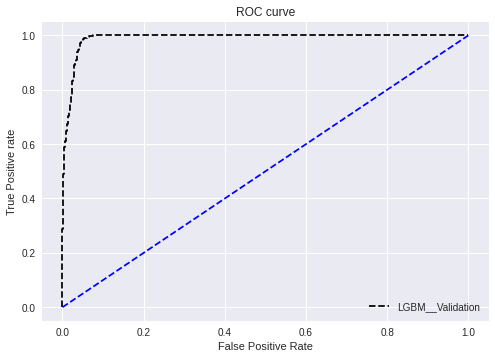

In [ ]:
#Without tuning
clf=LGBMClassifier()
lgbm_oofs,lgb_preds=run_clf_kfold(clf,train,test,features)


**Predictions**

In [ ]:
lgb_preds_rounded=lgb_preds.round()

In [ ]:
test['prob']=np.zeros((len(test)))
#prediction
preds_test=clf.predict(X_test)
#probability
preds_test_proba=clf.predict_proba(X_test)
download_preds(preds_test,preds_test_proba,file_name='LGB_preds.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>